# Restricciones cosmológicas mejoradas a partir de un análisis de conjunto de las muestras de supernovas SDSS-II y SNLS

In [1]:
%pylab inline
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import scipy.stats as st
import math
import random
import scipy.optimize as op
from scipy.optimize import fmin
import seaborn as sb
from cycler import cycler
import emcee
import corner


alpha_true = 0.141
om_true = 0.294
beta_true = 3.101
M_b_true = -19.05
delta_Mb = -0.070
#f_true = 0.534

Populating the interactive namespace from numpy and matplotlib


In [28]:
a1 = np.loadtxt('jla_mub_covmatrix.dat')
a2 = np.loadtxt('jla_mub.txt')
a3 = np.loadtxt('jla_lcparams.txt', usecols=[1,2,4,6,8,10,12,13,14,15])
a4 = np.loadtxt('jla_v0a_covmatrix.dat')
a5 = np.loadtxt('jla_v0b_covmatrix.dat')
a6 = np.loadtxt('jla_v0_covmatrix.dat')
a7 = np.loadtxt('jla_vab_covmatrix.dat')
a8 = np.loadtxt('jla_va_covmatrix.dat')
a9 = np.loadtxt('jla_vb_covmatrix.dat')


In [18]:
z=a2[:,0]
mu=a2[:,1]

z_cmb = a3[:,0]
z_hel = a3[:,1]
mb = a3[:,2]
x1 = a3[:,3]   
color = a3[:,4]   
rdvar_3 = a3[:,5]
tmax = a3[:,6]
cov_m_s = a3[:,7]
cov_m_c = a3[:,8]
cov_s_c = a3[:,9]

In [45]:
def eta(a,om):
    s3=(1.-om)/om
    s2=s3**(2./3)
    s=s3**(1./3)
    coef=[0.1540,0.4304,0.19097,0.066941]
    return 2.*np.sqrt(s3+1.)*((1./a**4)-coef[0]*s*(1./a**3)+coef[1]*s2*(1./a**2)+coef[2]*s3*(1./a)+coef[3]*(s**4))**(-1./8)

In [44]:
def sup(om,z):
    om = om
    c=299792.0 # velocidad de la luz en km/s
    a=1./(1+z)
    D =(c/70.0)*(1./a)*(eta(1.,om)-eta(a,om))
    y = 25.0-(5.*np.log10(70.0/100.0))+5.*np.log10(D)
    return y

In [6]:
f1=np.loadtxt('jla_mub_covmatrix.dat',delimiter = '\t',skiprows=0,usecols=[0,0]) 
covmatrix=f1[:,0]
n=np.size(covmatrix) 

In [14]:
def mu(mb,M_b,delta_Mb,alpha,beta,c,x_1):
    mu = mb-((M_b+delta_Mb)- alpha*x_1 + beta+c)
    return mu 

In [16]:
def lnlike(theta, z, y, var2):
    M_b, delta_Mb, alpha, beta = theta
    y = sup(om_true,z)
    model = mu(mb,M_b,delta_Mb,alpha,beta,color,x_1)
    inv_sigma2 = 1.0/(var2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [17]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
bnds= ((-20.0,-18.0),(-0.05,-0.2),(4.0,5.0),(-0.08,-0.05))
result= op.minimize(nll,[-19, -0.065, 0.125, 4.5], args=(zcmb, sup(om_true,zcmb), var2), bounds=bnds)
M_b, d_Mb, alpha, beta = result["x"]

In [18]:
print(M_b, d_Mb, alpha, beta)

(-19.0, -0.065000000000000002, 0.125, 4.5)


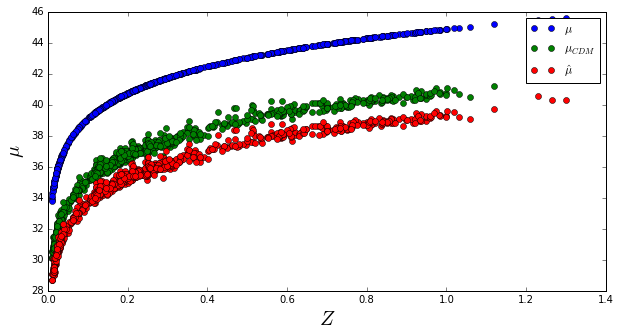

In [19]:
#plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.plot(zcmb,sup(om_true,zcmb),'o',label='$\mu$')
y1 = mu(mb,M_b_true,delta_Mb,alpha_true,beta_true,color,x_1)
plt.plot(zcmb,y1,'o',label='$\mu_{CDM}$')
y2 = mu(mb,M_b,d_Mb,alpha,beta,color,x_1)
plt.plot(zcmb,y2,'o', label='$\hat{\mu}$')
plt.xlabel('$Z$',fontsize = 20)
plt.ylabel('$\mu$',fontsize = 20)
plt.legend()
plt.show()

### Ahora vamos a definir el modelo que necesitamos

$\mu = 5log_{10}(d_{L}/10pc)$

$\mu = m^\star_{B} - (M_{B} - \alpha \times X_{1} + \beta \times C)$   

$\chi^2 = (\hat{\mu} - \mu_{\Lambda CDM}(z;\Omega_m))^{\dagger} C^{-1} (\hat{\mu} - \mu_{\Lambda CDM}(Z;\Omega))$

In [33]:
data = np.loadtxt('jla_mub.txt').T
cov_mat = np.loadtxt('jla_mub_covmatrix.dat').T
cov_mat = np.reshape(cov_mat,(-1,31))
invcov = np.linalg.inv(cov_mat)
H0 = 100
z = data 
c = 3e5
alfa = 0.1
beta = 3
Mb = -10
delta_M = -0.01
omg_m = 0.15

theta = Mb, delta_M, alfa, beta, omg_m




In [34]:
#Redefinimos mu
def mu(th,z, mb, x1, color):
    Mb,delta_M,alf,b,omg = th
    return mb - (Mb + delta_M - alf*x1 + b*color)

def eta(a, Om):
    s3 = (1-Om)/Om 
    s2 = s3**(2/3)
    s = s3**(1/3)
    return 2*np.sqrt(s3+1)*((1/(a**4))-0.1540*s/(a**3)+0.4304*s2/(a**2)+0.19097*s3/a+(0.06694*s**4))**(-1/8)

def DL(z, H0, Om):
    return (c/H0)*(1+z)*(eta(1, Om)-eta(1/(1+z),Om))

def mucdm(z,H0,Om):
    return 25-5*np.log10(H0/100)+5*np.log10(DL(z, H0, Om))


In [35]:
def lnlh(x, theta):
    modelo=mu(data[0], theta[0],theta[1])
    diferencia = data[1]-modelo
    u=0
    u = np.dot(diferencia, invcov)
    u = np.dot(u,diferencia.T)
    u = -0.5 * np.sum(u)
    return u

def Markov(theta1, thetap):
    p1 = lnlh(1,theta1)
    pp = lnlh(1,thetap)
    if(pp>p1):
        return thetap
    else:
        w = np.random.rand()
        if(pp-p1>np.log(w)):
            return thetap
        else:
            return theta1
    return

In [36]:
Nmuestras = 1000
sigma1 = 1
sigma2 = 0.1

Ncadenas = 8
thetas = [50,0.3]
cadenas = []

for j in range(Ncadenas):
    thetas = np.array([np.random.normal(np.random.uniform(50, 100), sigma1), np.random.normal(thetas[1], sigma2)])
    for i in range(Nmuestras):
        if i==0:
            cadena = thetas
        else:
            thetat = np.array([np.random.normal(thetas[0], sigma1), np.random.normal(thetas[1], sigma2)])
            thetanuevo = Markov(thetas, thetat)
            cadena = np.vstack((cadena, thetanuevo))
            thetas = thetanuevo
    if j==0:
        cadenas = cadena
    else:
        cadenas = np.vstack((cadenas, cadena))

TypeError: mu() missing 2 required positional arguments: 'x1' and 'color'

In [37]:
x1 = cadenas[0:Nmuestras,0]
y1 = cadenas[0:Nmuestras,1]
x2 = cadenas[Nmuestras+1:Nmuestras*2,0]
y2 = cadenas[Nmuestras+1:Nmuestras*2,1]
x3 = cadenas[2*Nmuestras+1:Nmuestras*3,0]
y3 = cadenas[2*Nmuestras+1:Nmuestras*3,1]
x4 = cadenas[3*Nmuestras+1:Nmuestras*4,0]
y4 = cadenas[3*Nmuestras+1:Nmuestras*4,1]
x5 = cadenas[4*Nmuestras+1:Nmuestras*5,0]
y5 = cadenas[4*Nmuestras+1:Nmuestras*5,1]
x6 = cadenas[5*Nmuestras+1:Nmuestras*6,0]
y6 = cadenas[5*Nmuestras+1:Nmuestras*6,1]
x7 = cadenas[6*Nmuestras+1:Nmuestras*7,0]
y7 = cadenas[6*Nmuestras+1:Nmuestras*7,1]
x8 = cadenas[7*Nmuestras+1:Nmuestras*8,0]
y8 = cadenas[7*Nmuestras+1:Nmuestras*8,1]

TypeError: list indices must be integers or slices, not tuple

In [38]:
mu1 = mu(theta,z_cmb,mb,x1,color)
mu2 = mucdm(data[0], theta[0],theta[1])

/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


### Para estos datos el valor del likelihood nos da valores de la constante de Hubble cercanos a 83.8

ValueError: x and y must be the same size

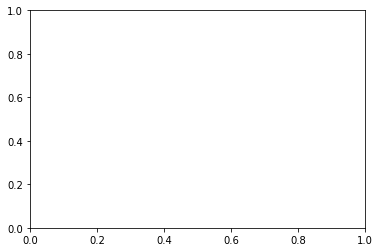

In [39]:
plt.scatter(x1, y1, color = 'g')
plt.scatter(x2, y2, color = 'r')
plt.scatter(x3, y3, color = 'y')
plt.scatter(x4, y4, color = 'b')
plt.scatter(x5, y5, color = 'c')
plt.scatter(x6, y6, color = 'm')
plt.scatter(x7, y7, color = 'k')
plt.scatter(x8, y8, color = 'w')

ValueError: x and y must be the same size

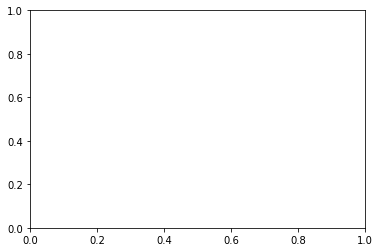

In [40]:
plt.scatter(x1, y1, color = 'g')
plt.scatter(x2, y2, color = 'r')
plt.scatter(x3, y3, color = 'y')
plt.scatter(x4, y4, color = 'b')
plt.scatter(x5, y5, color = 'c')
plt.scatter(x6, y6, color = 'm')
plt.scatter(x7, y7, color = 'k')
plt.scatter(x8, y8, color = 'w')
plt.xlim(80, 88)
plt.ylim(0.15, 0.5)

$P(\theta|x)=\frac{P(\theta \cap x)}{P(x)}=\frac{P(x|\theta)· P(\theta)}{P(x)}$

In [26]:
def lnprior(theta):
    H,omg,lnf=theta
    if 50 < H <100  and 0 < omg < 1.0 and -10.0 < lnf < 1.0 :
        return 0.0
    return -np.inf

def lnprob(theta,x,mu):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlh(1,theta)

In [19]:
omg_true = 0.290
H_true = 83.00
lnf_true = 0.0
H_ini,omg_ini,lnf_ini=50,0.5,0.5
nll = lambda * args: -lnlh(*args)
bounds=((74.0,84.0),(0.1,0.3),(0.0,1.0))
result = op.minimize(nll, [H_ini,omg_ini,lnf_ini], args=(z),bounds = bounds)
H_ml,omg_ml,lnf_ml=result["x"]

/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


In [27]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [28]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob , args=(z))

In [38]:
sampler.run_mcmc(pos,500)

(array([[ 8.46153202e+01,  2.80267876e-01, -3.42316720e+00],
        [ 8.33602870e+01,  3.10588441e-01, -6.53865403e+00],
        [ 8.36157833e+01,  3.40549881e-01, -6.94906210e+00],
        [ 8.44195878e+01,  2.63507828e-01, -1.77381283e+00],
        [ 8.39509472e+01,  2.57518928e-01, -6.96824368e+00],
        [ 8.39914245e+01,  2.45773743e-01, -7.75009891e+00],
        [ 8.39332978e+01,  3.21078104e-01, -5.14521793e-01],
        [ 8.39692984e+01,  2.85644675e-01, -7.96362254e+00],
        [ 8.36603753e+01,  3.09943192e-01, -7.80781871e+00],
        [ 8.39502694e+01,  3.24211083e-01, -5.88760176e+00],
        [ 8.34036530e+01,  3.53918586e-01, -5.58681435e+00],
        [ 8.39767116e+01,  2.81687229e-01, -2.73817194e+00],
        [ 8.38177678e+01,  2.93856714e-01, -3.41417919e+00],
        [ 8.46007363e+01,  2.47706590e-01, -8.79395919e+00],
        [ 8.43010904e+01,  2.92691676e-01, -9.22197507e+00],
        [ 8.39884398e+01,  3.09260440e-01, -5.50240643e-01],
        [ 8.40178991e+01

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

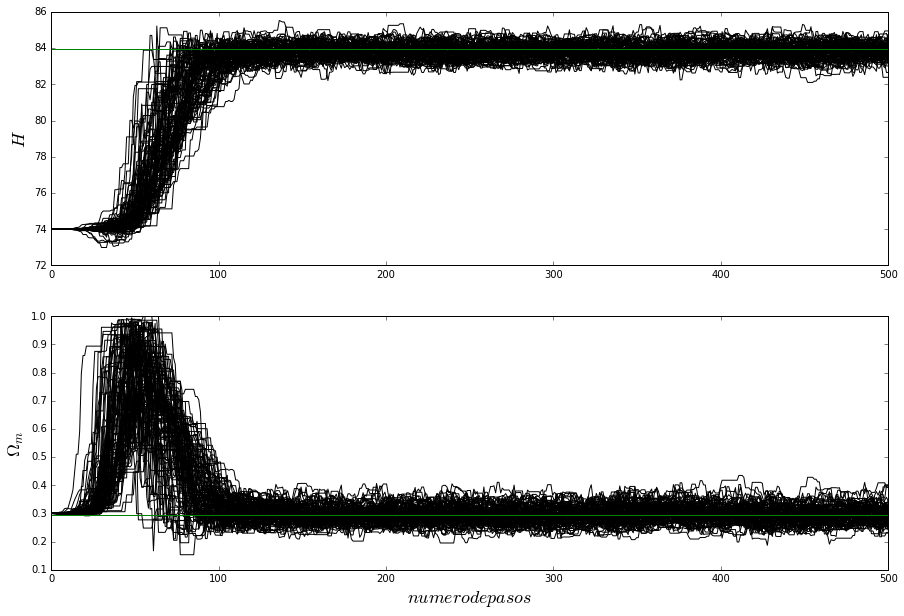

In [30]:
x_g = np.linspace(0.0, 500, 500)
y_H = 83.94 *np.ones(500)
y_omg = 0.294*np.ones(500)
plt.figure(figsize=(15,10))
for i in range(nwalkers):
    plt.subplot(2, 1, 1)
    plt.plot(x_g, sampler.chain[i,:,0], 'k-')
    plt.plot(x_g, y_H, '-')
    plt.ylabel('$H$',fontsize = 18)

    plt.subplot(2, 1, 2)
    plt.plot(x_g, sampler.chain[i,:,1], 'k-')
    plt.plot(x_g, y_omg, '-')
    plt.ylabel('$\Omega_m$',fontsize = 18)
    plt.xlabel('$numero de pasos$',fontsize = 18)
plt.show()

In [31]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


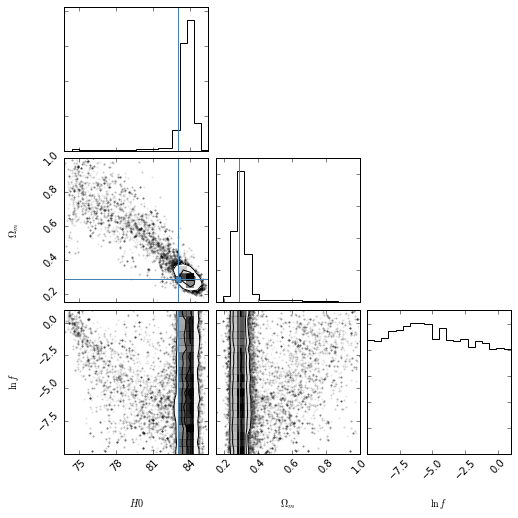

In [34]:

fig = corner.corner(samples, labels=["$H0$", "$\Omega_m$", "$\ln\,f$"],
                      truths=[H_true, omg_true, np.log(lnf_true)])
fig.savefig("Esquina.png")

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/luiscantero/anaconda3/lib/python3.6/site-p

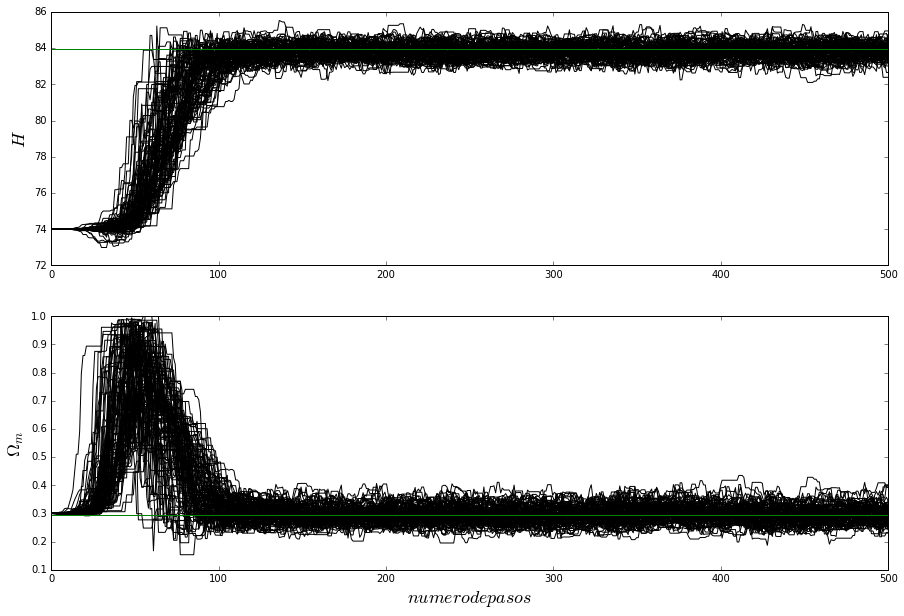

In [35]:
x_g = np.linspace(0.0, 500, 500)
y_H = 83.94 *np.ones(500)
y_omg = 0.294*np.ones(500)
plt.figure(figsize=(15,10))
for i in range(nwalkers):
    plt.subplot(2, 1, 1)
    plt.plot(x_g, sampler.chain[i,:,0], 'k-')
    plt.plot(x_g, y_H, '-')
    plt.ylabel('$H$',fontsize = 18)

    plt.subplot(2, 1, 2)
    plt.plot(x_g, sampler.chain[i,:,1], 'k-')
    plt.plot(x_g, y_omg, '-')
    plt.ylabel('$\Omega_m$',fontsize = 18)
    plt.xlabel('$numero de pasos$',fontsize = 18)
plt.show()

In [39]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

TypeError: 'function' object cannot be interpreted as an integer

/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


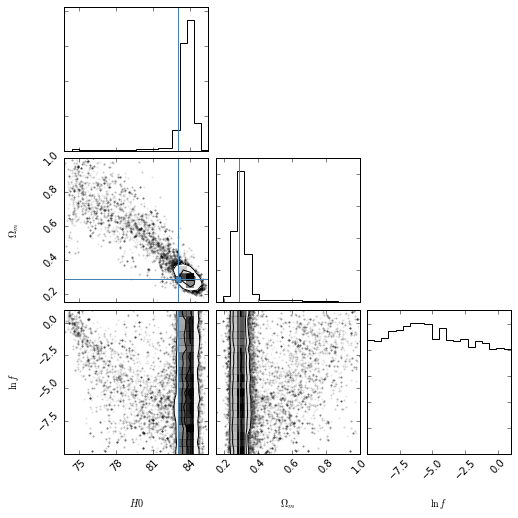

In [40]:

fig = corner.corner(samples, labels=["$H0$", "$\Omega_m$", "$\ln\,f$"],
                      truths=[H_true, omg_true, np.log(lnf_true)])
fig.savefig("Esquina2.png")



In [11]:
def lnprior(theta):
    H,omg,lnf=theta
    if 50 < H <100  and 0 < omg < 1.0 and -10.0 < lnf < 1.0 :
        return 0.0
    return -np.inf

def lnprob(theta,x,mu):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlh(1,theta)

In [46]:
mud = sup(om_true,data_f[:,0])

NameError: name 'data_f' is not defined

In [41]:
omg_true = 0.290
H_true = 83.00
lnf_true = 0.0
H_ini,omg_ini,lnf_ini=50,0.5,0.5
nll = lambda * args: -lnlh(*args)
bounds=((74.0,84.0),(0.1,0.3),(0.0,1.0))
result = op.minimize(nll, [H_ini,omg_ini,lnf_ini], args=(z),bounds = bounds)
H_ml,omg_ml,lnf_ml=result["x"]

/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
/home/luiscantero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


In [42]:
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

In [22]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(zcmb, mud, var2))

In [23]:
sampler.run_mcmc(pos, 500)
print()

()


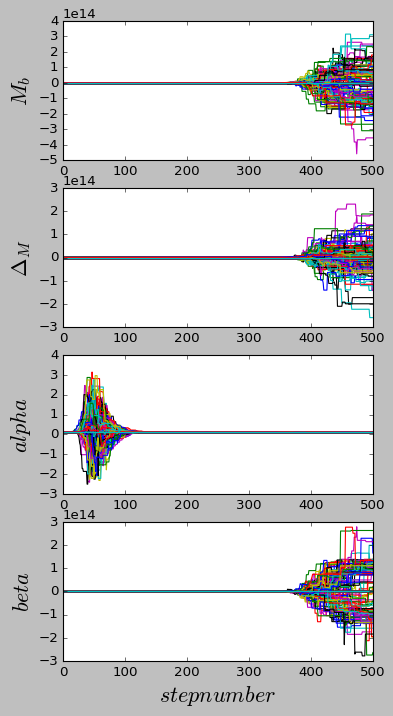

In [24]:
x1 = np.linspace(0.0, 500, 500)
plt.figure(figsize=(5,10))
for i in range(100):
    plt.subplot(4, 1, 1)
    plt.plot(x1, sampler.chain[i,:,0], '-')
    plt.plot(x1, M_b_true*np.ones(500), '-')
    plt.ylabel('$M_{b}$',fontsize = 20)

    plt.subplot(4, 1, 2)
    plt.plot(x1, sampler.chain[i,:,1], '-')
    plt.plot(x1, delta_Mb*np.ones(500), '-')
    plt.ylabel('$\Delta_{M}$',fontsize = 20)
    
    plt.subplot(4, 1, 3)
    plt.plot(x1, sampler.chain[i,:,2], '-')
    plt.plot(x1, alpha_true*np.ones(500), '-')
    plt.ylabel('$alpha$',fontsize = 20)
    
    plt.subplot(4, 1, 4)
    plt.plot(x1, sampler.chain[i,:,3], '-')
    plt.plot(x1, beta_true*np.ones(500), '-')
    plt.ylabel('$beta$',fontsize = 20)
    plt.xlabel('$stepnumber$',fontsize = 20)
plt.show()

In [25]:
samples = sampler.chain[:, 400:, :].reshape((-1, ndim))

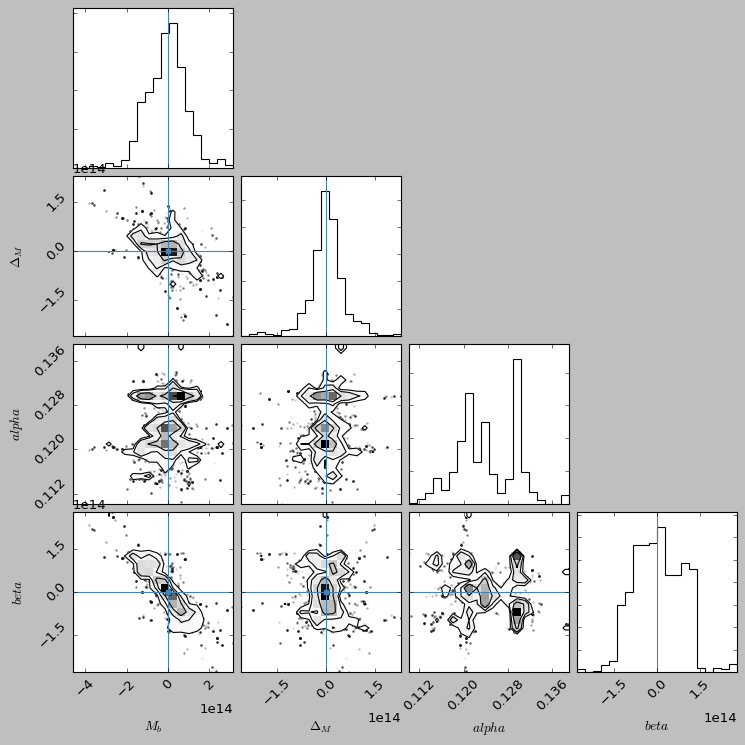

In [26]:
import corner
fig = corner.corner(samples, labels=["$M_{b}$", "$\Delta_{M}$", "$alpha$", "$beta$"],
                      truths=[M_b_true, delta_Mb, alpha_true, beta_true])
fig.savefig("1401.png")

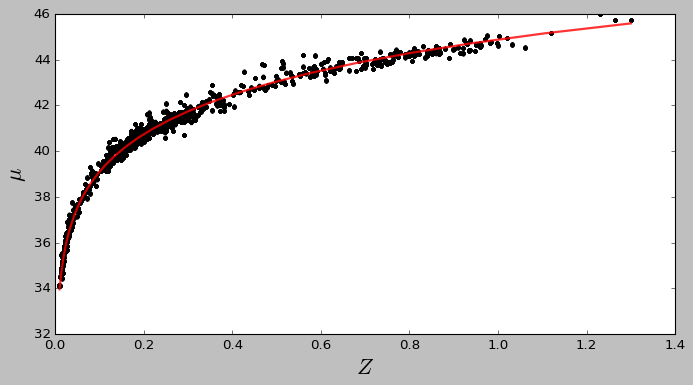

In [27]:
plt.figure(figsize=(10,5))
xl = np.array([0, 10])
for M_b, delta_Mb, alpha, beta in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(zcmb, mu(mb,M_b, delta_Mb, alpha, beta,color,x_1), 'k.', alpha=0.1)
plt.plot(z, sup(om_true,z), color="r", lw=2, alpha=0.8)
plt.xlabel('$Z$',fontsize = 20)
plt.ylabel('$\mu$',fontsize = 20)
plt.show()